In [5]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras



In [3]:


# Set the paths to your train, test, and validation directories
train_dir = "final_dataset/train"
test_dir = "final_dataset/test"
val_dir = "final_dataset/validation"

# Define the image size and number of classes
image_size = (224, 224)
num_classes = 101

# Create data generators with data augmentation for the train set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)

# Create data generators for the test and validation sets (no data augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical",
    shuffle=False  # Do not shuffle test data for evaluation
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)




Found 75750 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [6]:
# Load pre-trained EfficientNet B0 model with weights from ImageNet
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers[:-43]:  # Fine-tune the last 100 layers
    layer.trainable = True
for layer in base_model.layers[-43:]:
    layer.trainable = False

# Define the top layers for fine-tuning
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=output)



# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [8]:
# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    'efficient32_transfer_learning_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=13, verbose=1, restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)


In [9]:
import time
start_time = time.time()

In [10]:
# Train the model
history = model.fit(
        train_generator,
        epochs=300,
        validation_data=val_generator,
        callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr]
)


Epoch 1/300


2023-11-21 07:12:27.915843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500
2023-11-21 07:12:28.846663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4735/4735 [==============================] - ETA: 0s - loss: 2.1116 - accuracy: 0.4913
Epoch 1: val_loss improved from inf to 1.27769, saving model to efficient32_transfer_learning_model.h5
4735/4735 [==============================] - 679s 142ms/step - loss: 2.1116 - accuracy: 0.4913 - val_loss: 1.2777 - val_accuracy: 0.6665 - lr: 1.0000e-04
Epoch 2/300
4735/4735 [==============================] - ETA: 0s - loss: 1.2374 - accuracy: 0.6738
Epoch 2: val_loss improved from 1.27769 to 1.01092, saving model to efficient32_transfer_learning_model.h5
4735/4735 [==============================] - 671s 142ms/step - loss: 1.2374 - accuracy: 0.6738 - val_loss: 1.0109 - val_accuracy: 0.7274 - lr: 1.0000e-04
Epoch 3/300
4735/4735 [==============================] - ETA: 0s - loss: 1.0360 - accuracy: 0.7217
Epoch 3: val_loss improved from 1.01092 to 0.93758, saving model to efficient32_transfer_learning_model.h5
4735/4735 [==============================] - 668s 141ms/step - loss: 1.0360 - accuracy: 0.

In [11]:
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Total training time: 16430.36 seconds


In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")

947/947 [==============================] - 30s 32ms/step - loss: 0.8430 - accuracy: 0.7871
Test Loss: 0.8430
Test Accuracy: 78.71%


In [13]:
# Calculate metrics
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = [tf.argmax(pred).numpy() for pred in predictions]
y_true = test_generator.classes

947/947 [==============================] - 26s 27ms/step


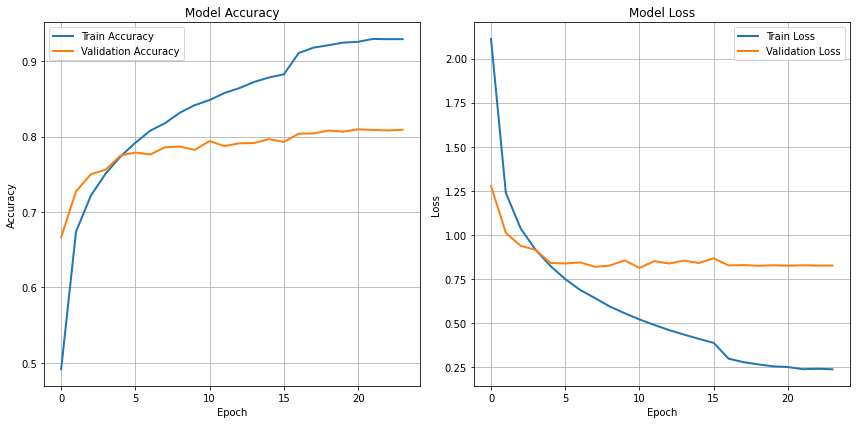

In [14]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load your pre-trained EfficientNet model (replace 'your_model.h5' with the actual model file)
from tensorflow.keras.models import load_model
model = load_model('efficint101-72.h5')

# Load your test image (replace 'test_image.jpg' with the path to your image)
img_path = 'testing/03-sushi.jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image based on how it was preprocessed during training
# You need to use the same preprocessing function as during training
# For example, if you used tf.keras.applications.efficientnet.preprocess_input during training:
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the class index with the highest confidence score
predicted_class_index = np.argmax(predictions)

# Map the class index to class name
class_names = ["apple_pie",
    "baby_back_ribs",
    "baklava",
    "beef_carpaccio",
    "beef_tartare",
    "beet_salad",
    "beignets",
    "bibimbap",
    "bread_pudding",
    "breakfast_burrito",
    "bruschetta",
    "caesar_salad",
    "cannoli",
    "caprese_salad",
    "carrot_cake",
    "ceviche",
    "cheese_plate",
    "cheesecake",
    "chicken_curry",
    "chicken_quesadilla",
    "chicken_wings",
    "chocolate_cake",
    "chocolate_mousse",
    "churros",
    "clam_chowder",
    "club_sandwich",
    "crab_cakes",
    "creme_brulee",
    "croque_madame",
    "cup_cakes",
    "deviled_eggs",
    "donuts",
    "dumplings",
    "edamame",
    "eggs_benedict",
    "escargots",
    "falafel",
    "filet_mignon",
    "fish_and_chips",
    "foie_gras",
    "french_fries",
    "french_onion_soup",
    "french_toast",
    "fried_calamari",
    "fried_rice",
    "frozen_yogurt",
    "garlic_bread",
    "gnocchi",
    "greek_salad",
    "grilled_cheese_sandwich",
    "grilled_salmon",
    "guacamole",
    "gyros",
    "hamburger",
    "hot_and_sour_soup",
    "hot_dog",
    "huevos_rancheros",
    "hummus",
    "ice_cream",
    "lasagna",
    "lobster_bisque",
    "lobster_roll_sandwich",
    "macaroni_and_cheese",
    "macarons",
    "miso_soup",
    "mussels",
    "nachos",
    "omelette",
    "onion_rings",
    "oysters",
    "pad_thai",
    "paella",
    "pancakes",
    "panna_cotta",
    "peking_duck",
    "pho",
    "pizza",
    "pork_chop",
    "poutine",
    "prime_rib",
    "pulled_pork_sandwich",
    "ramen",
    "ravioli",
    "red_velvet_cake",
    "risotto",
    "samosa",
    "sashimi",
    "scallops",
    "seaweed_salad",
    "shrimp_and_grits",
    "spaghetti_bolognese",
    "spaghetti_carbonara",
    "spring_rolls",
    "steak",
    "strawberry_shortcake",
    "sushi",
    "tacos",
    "takoyaki",
    "tiramisu",
    "tuna_tartare",
    "waffles"]  # Replace with your actual class names
predicted_class_name = class_names[predicted_class_index]

# Get the confidence score for the predicted class
confidence_score = predictions[0][predicted_class_index]

# Print the results
print(f'Predicted Class: {predicted_class_name}')
print(f'Confidence Score: {confidence_score:.2f}')


2023-11-22 06:18:37.311142: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 06:18:37.794001: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-11-22 06:18:37.794136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33615 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


NameError: name 'tf' is not defined